In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

mnist_trainset_small =  [ mnist_trainset[i] for i in range(0,60000) ] 
mnist_testset_small =  [ mnist_trainset[i] for i in range(0,10000) ] 


In [2]:
def calibration_curve(mnist_trainset_small,mnist_testset_small,input_dim,hidden_layer,output_layer,learning_rate,kf):
    epochs = 1
    class Cov_Net(nn.Module):   
        def __init__(self):
            super(Cov_Net, self).__init__()   
            self.layer1 = nn.Sequential(
                nn.Conv2d(input_dim, hidden_layer[0], kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(hidden_layer[0], hidden_layer[1], kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(hidden_layer[1], hidden_layer[2], kernel_size=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.drop_out = nn.Dropout()
            self.fc1 = nn.Linear(hidden_layer[3], hidden_layer[4])
            self.layer4 = nn.Sequential(
            nn.Linear(hidden_layer[4], output_layer),
            nn.LogSoftmax(dim=1))

        # Defining the forward pass    
        def forward(self, x):
            y = self.layer1(x)
            y = self.layer2(y)
            #y = self.layer3(y)
            y = y.view(-1, 32*5)
            y = self.drop_out(y)
            y = self.fc1(y)
            y = self.layer4(y)
            return y
    
    c_net = Cov_Net()
    
    def ccp(X_train,X_test,y_train):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = c_net(X_fold).numpy()
            c_score_one = c_net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values) 
    
    
    trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=128, shuffle=True)
    
    optimizer1 = optim.RMSprop( c_net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 

    n_mini_batches = 0
    for i, mini_batch in enumerate( trainloader, 0 ):
        images_train, labels_train = mini_batch
        optimizer1.zero_grad()         
        outputs_train = c_net(images_train)
        loss = loss_function ( outputs_train, labels_train )
        loss.backward()
        optimizer1.step()   
        n_mini_batches += 1 

    with torch.no_grad():
        for data in testloader: 
            images_test, labels_test = data     
            y_p_values_CCP = ccp(images_train,images_test,labels_train)

            #plotting calibration curve
            %matplotlib inline
            import matplotlib.pyplot as plt
            significance = np.zeros(100)
            error_rate = np.zeros(100)
            for k in range(100):
                significance[k] = k/100
                error_rate[k] = 0
                for j in range(len(labels_test)):
                    if (y_p_values_CCP[j,labels_test[j]] <= significance[k]):
                        error_rate[k] = error_rate[k] + 1
                error_rate[k] = error_rate[k] / len(labels_test)
            plt.plot(significance,error_rate)
            plt.title('Calibration Curve for Fashion Mnist dataset')
            plt.grid()
            
            #calculating average false p value
            avg_false_p_value = 0
            row_sum = 0
            r, c = y_p_values_CCP.shape
            for index_l,n in enumerate(labels_test):                           
                for p_value_index,m in enumerate(y_p_values_CCP): 
                    if index_l == p_value_index: 
                        sum_num = 0
                        for index, o in enumerate(y_p_values_CCP[p_value_index]): 
                            if int(n) != index:                                  
                                sum_num = sum_num+o
                        avg_rowwise = sum_num
                        row_sum = row_sum + avg_rowwise
            avg_false_p_value = row_sum/(y_p_values_CCP.size-r)
            return avg_false_p_value
    

Average false P-value for Cross Conformal Predictor with neural Network is  0.4632161458333334


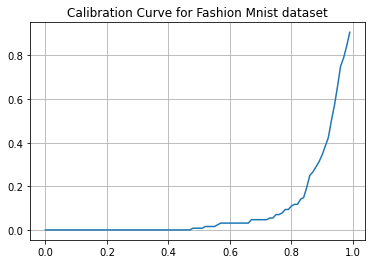

In [3]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 1
hidden_layer = [5,10,10,160,20,10]
output_layer = 10
learning_rate = 0.0001

avg_false_p_value = 0

avg_false_p_value = calibration_curve(mnist_trainset_small,mnist_testset_small,input_dim,hidden_layer,output_layer,learning_rate,kf)
print("Average false P-value for Cross Conformal Predictor with neural Network is ",avg_false_p_value)

In [4]:
def CNN_with_CCP(mnist_trainset_small,mnist_testset_small,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    
    class Cov_Net(nn.Module):   
        def __init__(self):
            super(Cov_Net, self).__init__()   
            self.layer1 = nn.Sequential(
                nn.Conv2d(input_dim, hidden_layer[0], kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(hidden_layer[0], hidden_layer[1], kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(hidden_layer[1], hidden_layer[2], kernel_size=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.drop_out = nn.Dropout(0.25)
            self.fc1 = nn.Linear(hidden_layer[3], hidden_layer[4])
            self.layer4 = nn.Sequential(
            nn.Linear(hidden_layer[4], output_layer),
            nn.LogSoftmax(dim=1))

        # Defining the forward pass    
        def forward(self, x):
            y = self.layer1(x)
            y = self.layer2(y)
            y = y.view(-1, 32*5)
            y = self.drop_out(y)
            y = self.fc1(y)
            y = self.layer4(y)
            return y
    
    c_net = Cov_Net()
    
    def ccp(X_train,X_test,y_train):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = c_net(X_fold).numpy()
            c_score_one = c_net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values) 
    
    
    trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=128, shuffle=True)
    
    optimizer1 = optim.RMSprop( c_net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    
    #epoch_no = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))
    loss_train = np.zeros((epochs,))
    accuracy_test_CPP = np.zeros((epochs,))
    accuracy_test_NN = np.zeros((epochs,))

    for epoch in range(epochs): # number of times to loop over the dataset
        n_mini_batches = 0
        error_train = 0
        total_train = 0
        
        for i, mini_batch in enumerate( trainloader, 0 ):
            images_train, labels_train = mini_batch
            optimizer1.zero_grad()         
            outputs_train = c_net(images_train)
            total_train += labels_train.size(0)
            _, predicted_train = torch.max( outputs_train, dim=1)
            error_train += (predicted_train != labels_train).sum().item()
            loss = loss_function ( outputs_train, labels_train )
            loss.backward()
            optimizer1.step()   
            n_mini_batches += 1 
        loss_train[epoch] = error_train / total_train
        
        correct_CNN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        with torch.no_grad():
            for data in testloader: 
                images_test, labels_test = data
                
                outputs = c_net(images_test)      
                _, predicted_test = torch.max( outputs, dim=1)
                error_test += (predicted_test != labels_test).sum().item()
                cnn_accuracy += (predicted_test == labels_test).sum().item()
                
                y_p_values_CCP = ccp(images_train,images_test,labels_train)
                y_p_values_CCP_tensor = torch.from_numpy(y_p_values_CCP)
                _, predict_CCP = torch.max( y_p_values_CCP_tensor, dim=1)
                ccp_accuracy += (predict_CCP == labels_test).sum().item()                
                #y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)         
                loss_te = loss_function ( outputs, labels_test ) 
                
                correct_CNN += (predicted_test == labels_test).float().sum()
                total += labels_test.size(0)
                correct_CPP += (predict_CCP == labels_test).float().sum()
                
        accuracy_test_NN[epoch] = correct_CNN / total
        accuracy_test_CPP[epoch] = correct_CPP / total
        loss_test[epoch] = error_test / total
        #epoch_no[epoch] = epoch
    
    return loss_train,loss_test,accuracy_test_NN,accuracy_test_CPP   

Enter your Hyper Parameter for CNN here

In [5]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state = 301
kf = KFold(shuffle=True, random_state=ran_state) 
input_dim = 1
hidden_layer = [5,10,10,160,20,10]
output_layer = 10
learning_rate = 0.0001

#epochs = 300
epochs = 50


loss_train_CNN = np.zeros((epochs,))
loss_test_CNN = np.zeros((epochs,))
accuracy_test_CNN = np.zeros((epochs,))
accuracy_test_CCP_CNN = np.zeros((epochs,))

loss_train_CNN, loss_test_CNN, accuracy_test_CNN, accuracy_test_CCP_CNN = CNN_with_CCP(mnist_trainset_small,mnist_testset_small,
                                                                          input_dim,hidden_layer,output_layer,learning_rate,epochs,kf)

In [6]:
print("Training Loss of the model: ",loss_train_CNN[-1])  
print("Testing Loss of the model: ",loss_test_CNN[-1]) 
print("Accuracy of the model between True Label and NN: ",accuracy_test_CNN[-1])
print("Accuracy of the model between True Label and CCP: ",accuracy_test_CCP_CNN[-1])

Training Loss of the model:  0.17673333333333333
Testing Loss of the model:  0.1861
Accuracy of the model between True Label and NN:  0.8138999938964844
Accuracy of the model between True Label and CCP:  0.8080000281333923


In [7]:
epoch_no = list(range(0, epochs))

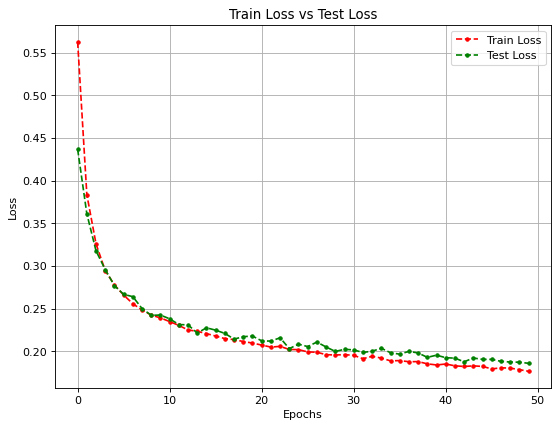

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
               
plt.plot(epoch_no, loss_train_CNN, 'r.--')
plt.plot(epoch_no, loss_test_CNN, 'g.--')
plt.legend(('Train Loss','Test Loss'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.grid()

Text(0.5, 1.0, 'Train Label vs CNN Test Accuracy')

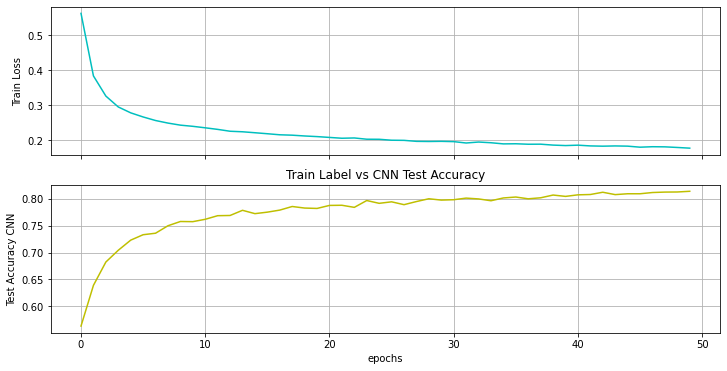

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(epoch_no,loss_train_CNN, color = 'c')
ax1.set_ylabel("Train Loss")
ax1.grid()
ax2.plot(epoch_no,accuracy_test_CNN, color='y')
ax2.set_ylabel("Test Accuracy CNN")
ax2.set_xlabel("epochs");
ax2.grid()
plt.title('Train Label vs CNN Test Accuracy')

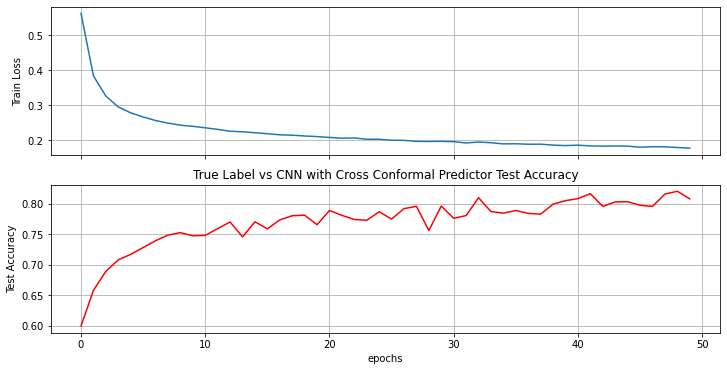

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_train_CNN)
ax1.set_ylabel("Train Loss")
ax1.grid()
ax2.plot(accuracy_test_CCP_CNN, color='r')
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("epochs");
plt.title('True Label vs CNN with Cross Conformal Predictor Test Accuracy')
ax2.grid()

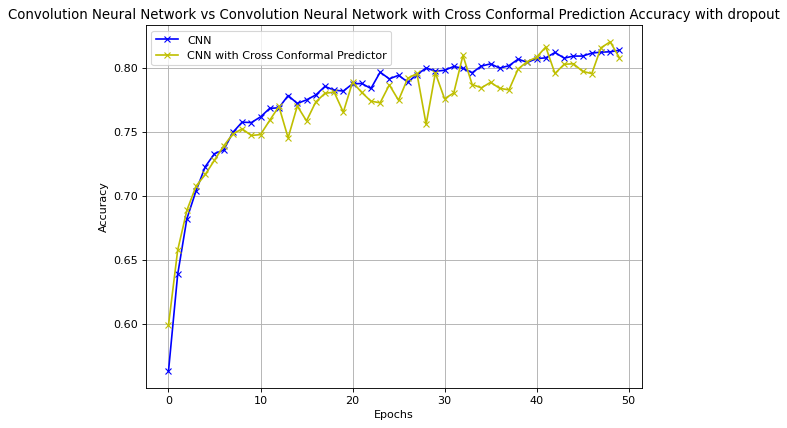

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

epoch_no = list(range(0, epochs))
plt.plot(epoch_no, accuracy_test_CNN, 'bx-')
plt.plot(epoch_no, accuracy_test_CCP_CNN, 'yx-')
plt.title('Convolution Neural Network vs Convolution Neural Network with Cross Conformal Prediction Accuracy with dropout')
plt.legend(('CNN','CNN with Cross Conformal Predictor'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline
from torch.autograd import Variable

#importing Fashion Mnist dataset
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_list)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()

X_train = X_train[:60000,:,:]
y_train = y_train[:60000]
X_test = X_test[:10000,:,:]
y_test = y_test[:10000]

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


In [13]:
def neural_network_with_CCP(X_train,X_test,y_train,y_test,input_dim,hidden_layer,output_layer,learning_rate,epochs,kf):
    X_train_nn = Variable(torch.from_numpy(X_train)).float()
    y_train_nn = Variable(torch.from_numpy(y_train)).long()
    X_test_nn  = Variable(torch.from_numpy(X_test)).float()
    y_test_nn  = Variable(torch.from_numpy(y_test)).long()
    
    class N_Net( nn.Module ):    
        def __init__(self):
            super(N_Net, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(input_dim,hidden_layer[0]),
                nn.ReLU(),
                nn.Linear(hidden_layer[0], hidden_layer[1]), 
                nn.ReLU(),
                nn.Linear(hidden_layer[1], output_layer),
                nn.LogSoftmax(dim=1))
        
        def forward(self, x):
            x1 = self.layers(x)
            return x1
        
    n_Net = N_Net()
    
    #cross conformal prediction for Neural Network
    def ccp(X_train,X_test,y_train,kf):
        rank_of_folds = None
        for rest_i, fold_i in kf.split(X_train):
            X_rest, X_fold = X_train[rest_i], X_train[fold_i]
            y_rest, y_fold = y_train[rest_i], y_train[fold_i] 
            c_score_fold = n_Net(X_fold).numpy()
            c_score_one = n_Net(X_test).numpy()
            rank_fold = None
            for each in c_score_one:
                rank = np.sum(c_score_fold<each,0)+1
                if rank_fold is None:
                    rank_fold = [rank-1]
                else:
                    rank_fold = np.vstack((rank_fold,[rank-1]))
            if rank_of_folds is None:
                rank_of_folds = [rank_fold]
            else:
                rank_of_folds = np.vstack((rank_of_folds, [rank_fold]))
        sum_ranks = np.sum(rank_of_folds,0)
        p_values = (sum_ranks+1)/len(y_train)
        return(p_values)   

    loss_train = np.zeros((epochs,))
    loss_test = np.zeros((epochs,))

    accuracy_test_CCP_True = np.zeros((epochs,))
    accuracy_test_NN_True = np.zeros((epochs,))

    optimizer1 = optim.RMSprop( n_Net.parameters(), lr=learning_rate )
    loss_function = nn.CrossEntropyLoss() 
    true_test_label = y_test_nn.numpy()
    error_train = 0

    for epoch in range(epochs):
        total_train = 0
        error_train = 0
        optimizer1.zero_grad()
        y_pred_train_NN = n_Net(X_train_nn)
        loss_NN = loss_function(y_pred_train_NN, y_train_nn)
        
        total_train += y_train_nn.size(0)
        loss_t = loss_NN.item()
        loss_train[epoch] = 100 * loss_t / total_train
        loss_NN.backward()
        optimizer1.step()
        
        
        correct_NN = 0 
        correct_CPP = 0 
        total = 0 
        error_test = 0
        cnn_accuracy = 0
        ccp_accuracy = 0
        
        with torch.no_grad():
            y_pred_NN = n_Net(X_test_nn).numpy()
            y_p_values_CCP = ccp(X_train_nn,X_test_nn,y_train_nn,kf)
            y_hat_CCP = np.argmax(y_p_values_CCP,axis=1)
            y_pred_NN_loss = n_Net(X_test_nn)
            loss_test_CNN = loss_function(y_pred_NN_loss, y_test_nn)
            #loss_test[epoch] = loss_test_CNN.item() 
            error_test = loss_test_CNN.item()
            y_predicted_NN = np.argmax(y_pred_NN,axis = 1)
            correct_NN = np.mean(y_predicted_NN==true_test_label)
            correct_CPP = np.mean(y_hat_CCP==true_test_label)
            total += y_test_nn.size(0)
            
        accuracy_test_NN_True[epoch] = correct_NN
        accuracy_test_CCP_True[epoch] = correct_CPP
        loss_test[epoch] = 100 * error_test / total
           
    return loss_train,loss_test,accuracy_test_NN_True,accuracy_test_CCP_True

In [14]:
#Hyper parameters
from sklearn.model_selection import KFold 
ran_state_1 = 301
kf_1 = KFold(shuffle=True, random_state=ran_state) 
input_dim_1 = 28*28
hidden_layer_1 = [300,200]
output_layer_1 = 10
learning_rate_1 = 0.0001

#epochs = 100


loss_train = np.zeros((epochs,))
loss_test = np.zeros((epochs,))
accuracy_test_NN_True = np.zeros((epochs,))
accuracy_test_CCP_True = np.zeros((epochs,))

loss_train, loss_test, accuracy_test_NN_True, accuracy_test_CCP_True = neural_network_with_CCP(X_train,X_test,y_train,y_test,
                                                                                               input_dim_1,hidden_layer_1,output_layer_1,learning_rate_1,epochs,kf_1)

In [15]:
print("Training Loss of the model: ",loss_train[-1])  
print("Testing Loss of the model: ",loss_test[-1]) 
print("Accuracy of the model between True Label and NN: ",accuracy_test_NN_True[-1])
print("Accuracy of the model between True Label and CCP: ",accuracy_test_CCP_True[-1])

Training Loss of the model:  0.0013129600882530212
Testing Loss of the model:  0.008610015511512756
Accuracy of the model between True Label and NN:  0.7674
Accuracy of the model between True Label and CCP:  0.7762


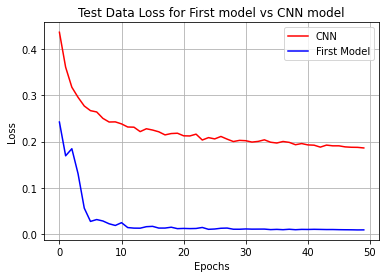

In [16]:
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, loss_test_CNN, color='r')
plt.plot(epoch_no, loss_test, color='b')
plt.title('Test Data Loss for First model vs CNN model')
plt.legend(('CNN','First Model'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

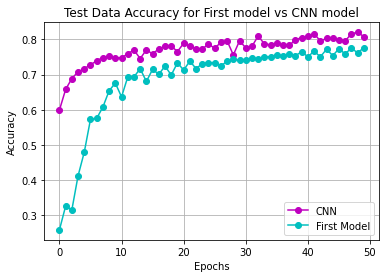

In [17]:
epoch_no = list(range(0, epochs))
plt.plot(epoch_no, accuracy_test_CCP_CNN, 'mo-')
plt.plot(epoch_no, accuracy_test_CCP_True, 'co-')
plt.title('Test Data Accuracy for First model vs CNN model')
plt.legend(('CNN','First Model'))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()